In [ ]:
# Music genre classification with CNN and ResNet Models
# Contributors: Blythe, Tyler, Anna
# 2023-03-11

Part 1: Data Loading and Visualization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
Train_data_path = '/content/drive/MyDrive/NewData_spotify/Split_Set/train'
Valid_data_path = '/content/drive/MyDrive/NewData_spotify/Split_Set/valid'
Test_data_path = '/content/drive/MyDrive/NewData_spotify/Split_Set/test'

In [3]:
# Basic imports
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from skimage.util import random_noise
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from math import floor 
import matplotlib.pyplot as plt

Data Augmentation 


*  Flips
*  Rotations
*  Translation
* Scaling
* Salt and Pepper Noise Addition






In [4]:
#Define transforms for the images (244 X 224 RGB)
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resizes the image to 224 x 224 pixels
    # transforms.CenterCrop(450),
    transforms.Resize(224),
    # transforms.RandomRotation(20),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),         # Converts the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.6526611249203121, 0.292953881382054, 0.46342994347954825],
        std=[0.014703215279531475, 0.0022068590777197432, 0.0022068590777197432],
    ),
])

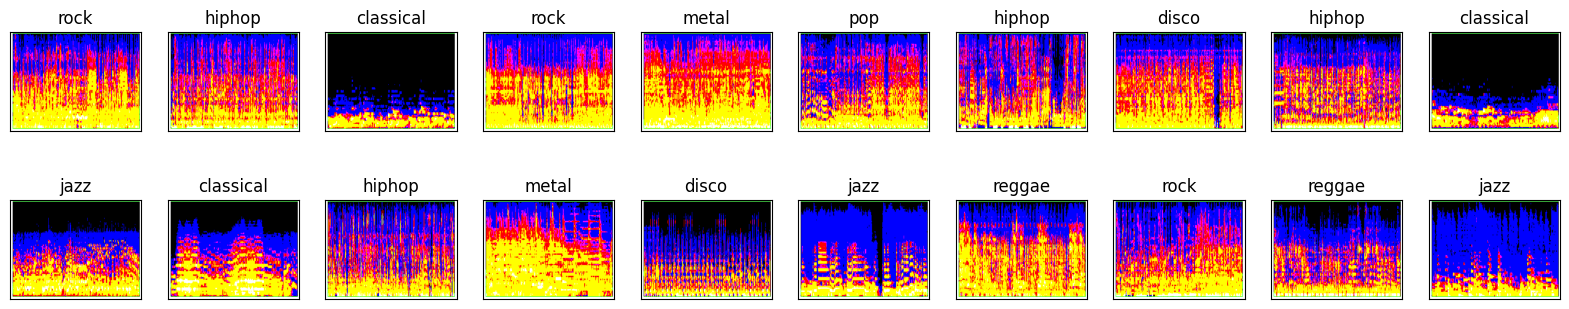

In [5]:
batch_size = 64
num_workers = 1

# define train dataset and set up the loader for train dataset  
train_dataset = ImageFolder(Train_data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)

# define valod dataset andt set up the loader for valid dataset  
valid_dataset = ImageFolder(Valid_data_path, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)

# define test dataset and set up the loader for test dataset  
test_dataset = ImageFolder(Test_data_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

#visualize data from train_loader 
classes = sorted(['rock','reggae','pop','metal','jazz','hiphop','disco','country','classical','blues'])


#obtain one batch of training images 
dataiter = iter(train_loader)
image, labels = next(dataiter)
images = image.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(classes[labels[i]])


In [ ]:
# # Get means and stdev for normalization
# color_means = [0,0,0]
# i = 0
# for images, labels in train_loader:
#   for image in images:
#     r, g, b = torch.mean(image, dim=[1,2])
#     # print(r,g,b)
#     color_means[0] += r.item()
#     color_means[1] += g.item()
#     color_means[2] += b.item()

#     i += 1

# color_means[0] /= i
# color_means[1] /= i
# color_means[2] /= i
# print(i, color_means)


KeyboardInterrupt: ignored

In [ ]:
# import math
# # Get means and stdev for normalization
# color_stdev = [0,0,0]
# i = 0
# for images, labels in train_loader:
#   for image in images:
#     r, g, b = torch.mean(image, dim=[1,2])
#     # print(r,g,b)
#     color_stdev[0] += (r.item() - color_means[0]) ** 2
#     color_stdev[1] += (g.item() - color_means[0]) ** 2
#     color_stdev[2] += (b.item() - color_means[0]) ** 2
#     i += 1

# color_means[0] = math.sqrt(color_means[0]/(i-1))
# color_means[1] = math.sqrt(color_means[0]/(i-1))
# color_means[2] = math.sqrt(color_means[0]/(i-1))
# print(i, color_means)


Part 2: Build CNN Model 

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=10, name="CNN"):
    super(CNN, self).__init__()
    self.name = name
    self.model = nn.Sequential(
    # Layer 1
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.15),
    # Layer 2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.15),
    # Layer 3
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.15),
    # Layer 4
    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.15),
    )
    # Define the fully connected layers
    self.fc_layers = nn.Sequential(
    nn.Linear(in_features=1605632, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=num_classes)
    )

  def forward(self, x):
    
    x = self.model(x)
    print(x.size())
    x = x.view(-1, 1605632)
    x = self.fc_layers(x)
    return x

RESNET TIME

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.dropout = nn.Dropout2d(0.3)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        #out = self.dropout(out)
        if self.downsample:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 32
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(32),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 32, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 64, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 128, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

Part 3: Training Code 

In [ ]:
def get_model_name(name, score):
    path = "model_{0}_acc_{1}".format(name, score)
    return path

In [ ]:
use_cuda = True

In [ ]:
def train(model, train_dataset, val_dataset, batch_size=32, num_epochs=20, learn_rate = 0.001):
    # Keep track of best trained model so far
    best_val_acc = 0
    
    #loss function and optimizer choice 
    loss_function = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    requirement = nn.BCEWithLogitsLoss()


    #intialize training and validation accuracy 
    #iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss=np.zeros(num_epochs)
    #train_loss = []
    #val_loss = []

    #train and validation loader 
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0

        correct = 0
        total_accuracy = 0
        for imgs, labels in iter(train_loader):
            optimizer.zero_grad()         # a clean up step for PyTorch

            #To Enable GPU Usage  
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates) 
            optimizer.step()              # make the updates for each parameter (weight)
            
            
            pred = out.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total_accuracy += imgs.shape[0]
        scheduler.step()

        train_acc[epoch] = correct/total_accuracy
        val_acc[epoch] = get_accuracy(model, val_loader)
        train_loss[epoch] = compute_loss(model, criterion, train_loader)
        val_loss[epoch] = compute_loss(model, criterion, val_loader)
        #+= 1 

        if(best_val_acc < val_acc[epoch]):
          best_val_acc = val_acc[epoch]
          print(f"New best validation accuracy: {best_val_acc}")
          model_path = get_model_name("ResNet18", best_val_acc)
          torch.save(model.state_dict(), model_path)

        print(("Epoch {}: Train acc: {} | " + "Train loss: {} |"+ "Validation acc: {} | "+ "Validation loss: {} |").format(epoch, train_acc[epoch],train_loss[epoch], val_acc[epoch],val_loss[epoch]))
        

    epochs = np.arange(1, num_epochs + 1)
    
    return train_acc, train_loss, val_acc, val_loss, epochs

In [ ]:
def compute_loss(model, criterion, dataloader, use_cuda=True):
    total_loss = 0.0
    total_samples = 0
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for imgs, labels in dataloader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)
    avg_loss = total_loss / total_samples
    return avg_loss

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
 
        #To Enable GPU Usage       
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

New best validation accuracy: 0.32040816326530613
Epoch 0: Train acc: 0.2367549668874172 | Train loss: 1.8726231012912775 |Validation acc: 0.32040816326530613 | Validation loss: 1.8781915849568893 |
New best validation accuracy: 0.3622448979591837
Epoch 1: Train acc: 0.330794701986755 | Train loss: 1.6457675092267674 |Validation acc: 0.3622448979591837 | Validation loss: 1.6747987907759998 |
New best validation accuracy: 0.3846938775510204
Epoch 2: Train acc: 0.4016556291390728 | Train loss: 1.5284247144168577 |Validation acc: 0.3846938775510204 | Validation loss: 1.5454504051987006 |
Epoch 3: Train acc: 0.4185430463576159 | Train loss: 1.533456800947126 |Validation acc: 0.37755102040816324 | Validation loss: 1.55160283847731 |
New best validation accuracy: 0.4561224489795918
Epoch 4: Train acc: 0.4390728476821192 | Train loss: 1.3989890093834985 |Validation acc: 0.4561224489795918 | Validation loss: 1.3717299067244237 |
New best validation accuracy: 0.4673469387755102
Epoch 5: Train a

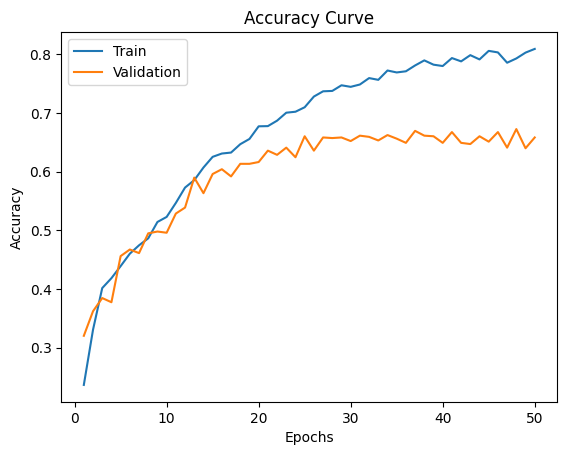

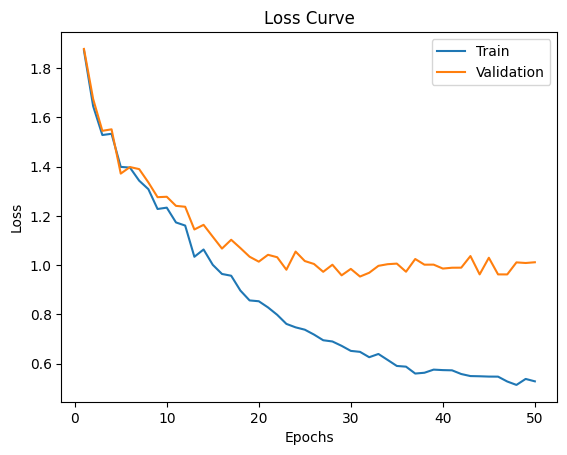

In [ ]:
# CNN_test = ResNet18()
# if use_cuda and torch.cuda.is_available():
#   CNN_test.cuda()

# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

train_acc, train_loss, val_acc, val_loss, epochs  = train(model, train_dataset, valid_dataset, num_epochs=50, learn_rate=0.015, batch_size=64)

# plotting
plt.title("Accuracy Curve")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Loss Curve")
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


#plt.plot(epochs, train_acc)
#plt.title("Training curve - primary model")
#plt.xlabel("Epochs")
#plt.ylabel("Training Accuracy")
#plt.show()

#plt.plot(epochs, val_acc)
#plt.title("Validation Curve  - primary model")
#plt.xlabel("Epochs")
#plt.ylabel("Validation Accuracy")
#plt.show()

In [ ]:
# param_count = 0
# for param in CNN_test.parameters():
#   print(param.shape)
#   param_count += len(param.shape)
# print("Total number of parameters in CNN: ", param_count)


Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load("model_ResNet18_acc_0.67"))
final_acc = get_accuracy(model, test_loader)
print(final_acc)

0.692


In [ ]:
Test_data_path = '/content/drive/MyDrive/Project/NewData_spotify/Split_Set/test'
batch_size = 64
num_workers = 1
# define test dataset and set up the loader for test dataset  
test_dataset = ImageFolder(Test_data_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load("model_ResNet18_acc_0.67"))
final_acc = get_accuracy(model, test_loader)
print(final_acc)

0.69


Demonstration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
demo_model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
demo_model.load_state_dict(torch.load("model_ResNet18_acc_0.67"))

classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# define demonstration dataset and set up the loader for test dataset  
demonstration_data_path = '/content/drive/MyDrive/Project/DemoSplit/FurElise'
demonstration_dataset = ImageFolder(demonstration_data_path, transform=transform)
demonstration_loader = torch.utils.data.DataLoader(demonstration_dataset, batch_size=1, 
                                           num_workers=num_workers, shuffle=True)

print(get_accuracy(model, demonstration_loader))
for images, labels in iter(demonstration_loader):
  for index, image in enumerate(images):
    images, labels = images.cuda(), labels.cuda()
    output = demo_model(images)
    probs = nn.Softmax(dim=1)
    output = probs(output)

    pred = output.max(1, keepdim=True)[1]
    correct = labels.view_as(pred)
    print(correct)
    
    for i,e in enumerate(output[index]):
      print(f"{classes[i]}: {e}")

    print(f"Predicts: {classes[pred[0][0]]}")


In [ ]:
output = demo_model(demonstration_loader)

probs = torch.nn.functional.softmax(output, dim=1)

for i, label in enumerate(classes):
    print("{}: {:.2%}".format(label, probs[0][i]))


Performance by class

In [ ]:
def demo_get_probs(model, data_loader):
    correct = 0
    total = 0
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    accuracy_per_class = [0 for g in genres]
    
    for imgs, labels in data_loader:
 
        #To Enable GPU Usage       
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        

        output = model(imgs)

        i, predictions = torch.max(output.data, 1)


        for g in genres:
            accuracy_per_class[g] = ((predictions == labels) * (labels == g)).float() / (max(labels == g).sum(), 1)

        
        #select index with maximum prediction score
        #pred = output.max(1, keepdim=True)[1]
        #correct += pred.eq(labels.view_as(pred)).sum().item()
        #total += imgs.shape[0]
    return accuracy_per_class

In [ ]:
# define test dataset and set up the loader for test dataset  
test_dataset = ImageFolder(Test_data_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
accuracy_per_class = demo_get_probs(model, test_loader)

print(accuracy_per_class)

plt.figure(figsize=(10,6))
plt.bar(genres, accuracy_per_class)
plt.xlabel("Music Genre")
plt.ylabel("Accuracy")
plt.title("ResNet Accuracy Across Different Genres")
plt.show()

TypeError: ignored

Total convolution layers: 19
conv_layers


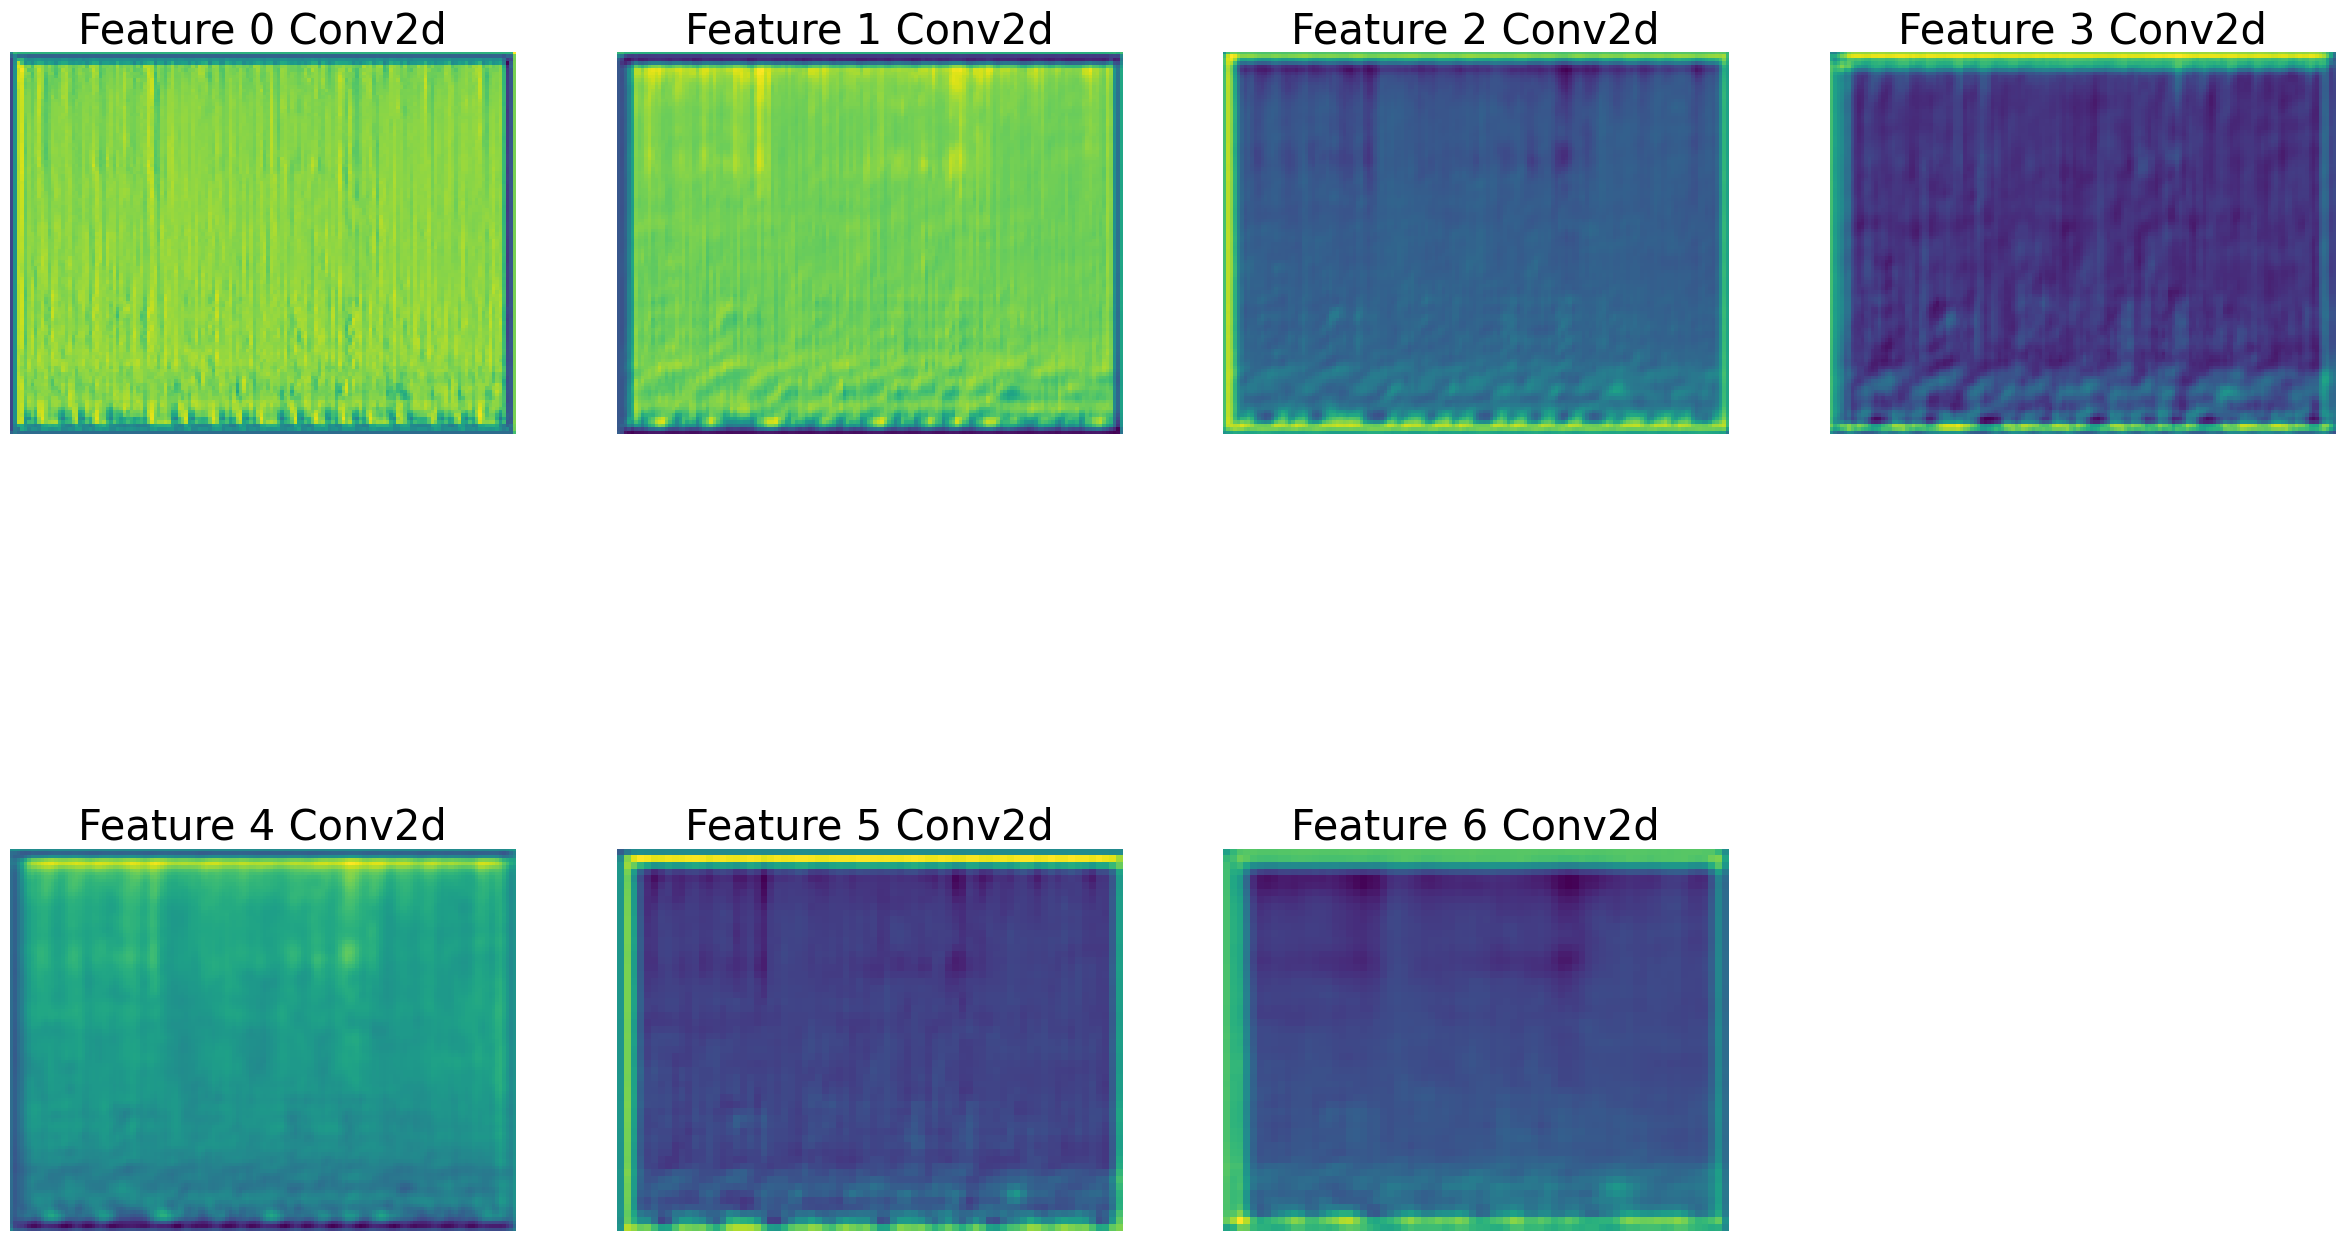

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load("model_ResNet18_acc_0.694"))

# First layer
layer1 = next(next(model.children()).children())
weight1 = layer1.weight
# Feature map visualization
# we will save the conv layer weights in this list
model_weights =[weight1]
#we will save the 49 conv layers in this list
conv_layers = [layer1]
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Sequential:
                    counter+=1
                    model_weights.append(child[0].weight)
                    conv_layers.append(child[0])
print(f"Total convolution layers: {counter}")
print("conv_layers")

outputs = []

demonstration_dataset = ImageFolder(demonstration_data_path, transform=transform)
demonstration_loader = torch.utils.data.DataLoader(demonstration_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
image = next(enumerate(demonstration_loader))[1][0].squeeze(0).cuda()

processed = []

for layer in conv_layers[0:7]:
  image = layer(image)
  processed.append(image)

for i in range(len(processed)):
  image = processed[i]
  image = image.squeeze(0)
  image = torch.sum(image,0)
  processed[i] = image.data.cpu().numpy()
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(f'Feature {i}', fontsize=30)
# plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
plt.show()

In [ ]:
next(next(model.children()).children())
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout2d(p=0, inplace=False)
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1):

In [ ]:
def get_genre_accuracy(model, data_loader):
    correct = [0]*10
    total = [0]*10
    acc = []
    count = 0
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    for images, labels in iter(data_loader):
        for index, image in enumerate(images):
            count += 1
            #print(count)
            images, labels = images.cuda(), labels.cuda()
            output = model(images)
            probs = nn.Softmax(dim=1)
            output = probs(output)

            for i in range(len(output)):
                predclass = torch.argmax(output[i])
                lab = labels[i].data
                #print(predclass, lab)
                total[lab] += 1
                if predclass == lab:
                    correct[predclass] += 1
                    

    for i in range(0,10):
        acc.append(correct[i]/total[i])

    
    return acc



[0.49000634517766495, 0.9579617834394905, 0.7054251269035533, 0.766624843161857, 0.7753880983182406, 0.8147914032869785, 0.6460977157360406, 0.5907079646017699, 0.7363035264483627, 0.27611464968152866]


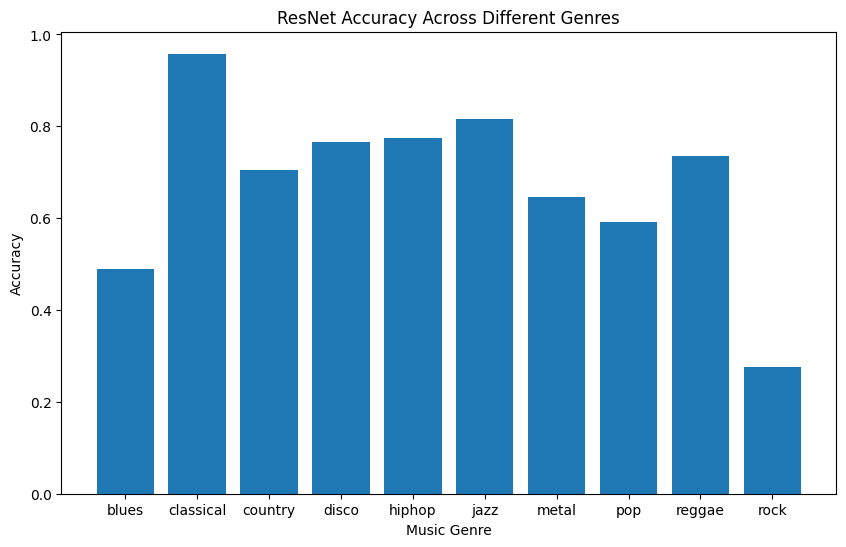

In [ ]:
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load("model_ResNet18_acc_0.67"))

# define test dataset and set up the loader for test dataset  
test_dataset = ImageFolder(Test_data_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
accuracy_per_class = get_genre_accuracy(model, test_loader)

print(accuracy_per_class)

plt.figure(figsize=(10,6))
plt.bar(genres, accuracy_per_class)
plt.xlabel("Music Genre")
plt.ylabel("Accuracy")
plt.title("ResNet Accuracy Across Different Genres")
plt.show()

Testing on NEW DATA

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load("model_ResNet18_acc_0.67"))

new_data_path = '/content/drive/MyDrive/Project/NewData_YT/Spectrograms'

batch_size = 64
num_workers = 1

# define test dataset and set up the loader for test dataset  
new_dataset = ImageFolder(new_data_path, transform=transform)
new_loader = torch.utils.data.DataLoader(new_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


In [ ]:
def get_top3_accuracy(model, data_loader):
    correct = 0
    total = 0
    count = 0
    for images, labels in iter(data_loader):
        for index, image in enumerate(images):
            count += 1
            print(count)
            images, labels = images.cuda(), labels.cuda()
            output = model(images)
            probs = nn.Softmax(dim=1)
            output = probs(output)

            for i in range(len(output)):
                top3 = torch.topk(output[i].flatten(), 3).indices
                lab = labels[i].data
                print(top3, lab, (lab in top3))
                total += 1
                if lab in top3:
                    correct += 1
                    

    acc = correct/total

    
    return acc

In [ ]:
get_top3_accuracy(model, new_loader)

1
tensor([9, 6, 0], device='cuda:0') tensor(6, device='cuda:0') True
tensor([3, 8, 0], device='cuda:0') tensor(5, device='cuda:0') False
tensor([7, 8, 4], device='cuda:0') tensor(8, device='cuda:0') True
tensor([3, 8, 0], device='cuda:0') tensor(8, device='cuda:0') True
tensor([9, 6, 2], device='cuda:0') tensor(9, device='cuda:0') True
tensor([2, 0, 7], device='cuda:0') tensor(9, device='cuda:0') False
tensor([0, 5, 6], device='cuda:0') tensor(0, device='cuda:0') True
tensor([2, 9, 7], device='cuda:0') tensor(7, device='cuda:0') True
tensor([3, 7, 4], device='cuda:0') tensor(1, device='cuda:0') False
tensor([9, 6, 4], device='cuda:0') tensor(2, device='cuda:0') False
tensor([2, 9, 6], device='cuda:0') tensor(2, device='cuda:0') True
tensor([3, 7, 4], device='cuda:0') tensor(3, device='cuda:0') True
tensor([0, 7, 9], device='cuda:0') tensor(7, device='cuda:0') True
tensor([0, 8, 5], device='cuda:0') tensor(5, device='cuda:0') True
tensor([4, 7, 9], device='cuda:0') tensor(6, device='cud

0.6825

In [ ]:
def get_top2_accuracy(model, data_loader):
    correct = 0
    total = 0
    count = 0
    for images, labels in iter(data_loader):
        for index, image in enumerate(images):
            count += 1
            print(count)
            images, labels = images.cuda(), labels.cuda()
            output = model(images)
            probs = nn.Softmax(dim=1)
            output = probs(output)

            for i in range(len(output)):
                top3 = torch.topk(output[i].flatten(), 2).indices
                lab = labels[i].data
                print(top3, lab, (lab in top3))
                total += 1
                if lab in top3:
                    correct += 1
                    

    acc = correct/total

    
    return acc

In [ ]:
get_top2_accuracy(model, new_loader)

1
tensor([9, 6], device='cuda:0') tensor(9, device='cuda:0') True
tensor([9, 6], device='cuda:0') tensor(6, device='cuda:0') True
tensor([3, 8], device='cuda:0') tensor(8, device='cuda:0') True
tensor([2, 7], device='cuda:0') tensor(9, device='cuda:0') False
tensor([0, 5], device='cuda:0') tensor(0, device='cuda:0') True
tensor([4, 9], device='cuda:0') tensor(4, device='cuda:0') True
tensor([2, 9], device='cuda:0') tensor(7, device='cuda:0') False
tensor([4, 7], device='cuda:0') tensor(3, device='cuda:0') False
tensor([8, 3], device='cuda:0') tensor(4, device='cuda:0') False
tensor([3, 0], device='cuda:0') tensor(5, device='cuda:0') False
tensor([4, 7], device='cuda:0') tensor(6, device='cuda:0') False
tensor([7, 8], device='cuda:0') tensor(8, device='cuda:0') True
tensor([3, 9], device='cuda:0') tensor(3, device='cuda:0') True
tensor([5, 1], device='cuda:0') tensor(0, device='cuda:0') False
tensor([5, 1], device='cuda:0') tensor(1, device='cuda:0') True
tensor([8, 0], device='cuda:0')

0.55

In [ ]:
def get_top1_accuracy(model, data_loader):
    correct = 0
    total = 0
    count = 0
    for images, labels in iter(data_loader):
        for index, image in enumerate(images):
            count += 1
            print(count)
            images, labels = images.cuda(), labels.cuda()
            output = model(images)
            probs = nn.Softmax(dim=1)
            output = probs(output)

            for i in range(len(output)):
                top3 = torch.topk(output[i].flatten(), 1).indices
                lab = labels[i].data
                print(top3, lab, (lab in top3))
                total += 1
                if lab in top3:
                    correct += 1
                    

    acc = correct/total

    
    return acc

In [ ]:
get_top1_accuracy(model, new_loader)

1
tensor([2], device='cuda:0') tensor(2, device='cuda:0') True
tensor([1], device='cuda:0') tensor(1, device='cuda:0') True
tensor([2], device='cuda:0') tensor(9, device='cuda:0') False
tensor([4], device='cuda:0') tensor(4, device='cuda:0') True
tensor([2], device='cuda:0') tensor(7, device='cuda:0') False
tensor([9], device='cuda:0') tensor(6, device='cuda:0') False
tensor([7], device='cuda:0') tensor(8, device='cuda:0') False
tensor([3], device='cuda:0') tensor(1, device='cuda:0') False
tensor([3], device='cuda:0') tensor(3, device='cuda:0') True
tensor([8], device='cuda:0') tensor(6, device='cuda:0') False
tensor([8], device='cuda:0') tensor(0, device='cuda:0') False
tensor([8], device='cuda:0') tensor(5, device='cuda:0') False
tensor([0], device='cuda:0') tensor(7, device='cuda:0') False
tensor([2], device='cuda:0') tensor(9, device='cuda:0') False
tensor([8], device='cuda:0') tensor(4, device='cuda:0') False
tensor([4], device='cuda:0') tensor(2, device='cuda:0') False
tensor([3]

0.34

New (Unique) Spotify Data

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load("model_ResNet18_acc_0.67"))

new_data_path = '/content/drive/MyDrive/Project/final_spectrograms'

batch_size = 64
num_workers = 1

# define test dataset and set up the loader for test dataset  
new_dataset = ImageFolder(new_data_path, transform=transform)
new_loader = torch.utils.data.DataLoader(new_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [ ]:
get_top1_accuracy(model, new_loader)

1
tensor([1], device='cuda:0') tensor(1, device='cuda:0') True
tensor([9], device='cuda:0') tensor(9, device='cuda:0') True
tensor([8], device='cuda:0') tensor(8, device='cuda:0') True
tensor([2], device='cuda:0') tensor(2, device='cuda:0') True
tensor([0], device='cuda:0') tensor(7, device='cuda:0') False
tensor([7], device='cuda:0') tensor(8, device='cuda:0') False
tensor([5], device='cuda:0') tensor(5, device='cuda:0') True
tensor([1], device='cuda:0') tensor(1, device='cuda:0') True
tensor([2], device='cuda:0') tensor(2, device='cuda:0') True
tensor([2], device='cuda:0') tensor(9, device='cuda:0') False
tensor([8], device='cuda:0') tensor(0, device='cuda:0') False
tensor([7], device='cuda:0') tensor(7, device='cuda:0') True
tensor([3], device='cuda:0') tensor(3, device='cuda:0') True
tensor([7], device='cuda:0') tensor(0, device='cuda:0') False
tensor([0], device='cuda:0') tensor(5, device='cuda:0') False
tensor([9], device='cuda:0') tensor(6, device='cuda:0') False
tensor([3], dev

0.5425

In [ ]:
get_top2_accuracy(model, new_loader)

1
tensor([0, 9], device='cuda:0') tensor(7, device='cuda:0') False
tensor([1, 5], device='cuda:0') tensor(1, device='cuda:0') True
tensor([9, 6], device='cuda:0') tensor(9, device='cuda:0') True
tensor([3, 9], device='cuda:0') tensor(3, device='cuda:0') True
tensor([1, 0], device='cuda:0') tensor(5, device='cuda:0') False
tensor([3, 4], device='cuda:0') tensor(3, device='cuda:0') True
tensor([2, 9], device='cuda:0') tensor(2, device='cuda:0') True
tensor([1, 5], device='cuda:0') tensor(1, device='cuda:0') True
tensor([8, 7], device='cuda:0') tensor(0, device='cuda:0') False
tensor([9, 6], device='cuda:0') tensor(6, device='cuda:0') True
tensor([5, 0], device='cuda:0') tensor(5, device='cuda:0') True
tensor([8, 0], device='cuda:0') tensor(0, device='cuda:0') True
tensor([7, 4], device='cuda:0') tensor(4, device='cuda:0') True
tensor([8, 0], device='cuda:0') tensor(8, device='cuda:0') True
tensor([2, 0], device='cuda:0') tensor(2, device='cuda:0') True
tensor([7, 4], device='cuda:0') ten

0.6475

In [ ]:
get_top3_accuracy(model, new_loader)

1
tensor([3, 9, 7], device='cuda:0') tensor(3, device='cuda:0') True
tensor([7, 4, 9], device='cuda:0') tensor(4, device='cuda:0') True
tensor([7, 8, 3], device='cuda:0') tensor(0, device='cuda:0') False
tensor([1, 5, 3], device='cuda:0') tensor(1, device='cuda:0') True
tensor([5, 3, 0], device='cuda:0') tensor(5, device='cuda:0') True
tensor([7, 4, 8], device='cuda:0') tensor(4, device='cuda:0') True
tensor([2, 0, 9], device='cuda:0') tensor(2, device='cuda:0') True
tensor([8, 0, 7], device='cuda:0') tensor(0, device='cuda:0') True
tensor([1, 5, 6], device='cuda:0') tensor(1, device='cuda:0') True
tensor([6, 9, 2], device='cuda:0') tensor(6, device='cuda:0') True
tensor([7, 2, 9], device='cuda:0') tensor(9, device='cuda:0') True
tensor([9, 6, 0], device='cuda:0') tensor(9, device='cuda:0') True
tensor([3, 8, 4], device='cuda:0') tensor(3, device='cuda:0') True
tensor([2, 0, 9], device='cuda:0') tensor(2, device='cuda:0') True
tensor([9, 6, 7], device='cuda:0') tensor(6, device='cuda:0

0.755